# **NEURAL NETWORKS**

## IMPORTING THE PACKAGES

In [53]:
from time import time
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt 
from keras.models import load_model
%tensorflow_version 2.x
import tensorflow
device_name = tensorflow.test.gpu_device_name()
tensorflow.device('/device:GPU:0')                  #This allows to use the COLAB gpu    
from tensorflow.keras.layers import Input         
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive                      #This allows to connect with google drive to save and load the results
drive.mount('/content/drive')

Mounted at /content/drive


## Reading the data

In [ ]:
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")
data

id         p     theta      beta  nphe       ein      eout
0         211  0.780041  1.081480  0.989962     0  0.000000  0.000000
1         211  0.260929  0.778892  0.902450     0  0.000000  0.000000
2        2212  0.773022  0.185953  0.642428     4  0.101900  0.000000
3         211  0.476997  0.445561  0.951471     0  0.000000  0.000000
4        2212  2.123290  0.337332  0.908652     0  0.034379  0.049256
...       ...       ...       ...       ...   ...       ...       ...
4999995   211  0.835889  0.495847  0.975812     0  0.000000  0.046967
4999996   211  2.027470  0.287966  1.222890     0  0.197894  0.186404
4999997   211  0.827497  0.689746  0.980957     0  0.000000  0.000000
4999998  2212  1.331200  0.382746  0.811818     0  0.036942  0.056947
4999999  2212  2.956890  0.449482  0.946111     0  0.106844  0.165438

[5000000 rows x 7 columns]

## Then 3 different models are tested: DNN, CNN, MLP

# **1st MODEL DNN**

In [52]:
def NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lamda):
    '''This function creates a NN model using the following parameters:
        Input:
        - inputsize: 
        - n_layers: number of hidden layers
        - n_neuron: number of neurons in each hidden layer
        - n_categories: number of outputs (4 different particles)
        - eta: learning rate
        - lamda: hyperparameter lambda
        Output
        - return all the model    
    '''
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(n_categories,activation='softmax'))  #4 outputs (softmax for probability)
    sgd=optimizers.SGD(learning_rate=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc'])
    return model

## Size study

Now, we evalute how the data size affects the accuracy

In [ ]:
#first we define the input variables for the NN
data_size = [500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000] 
eta = 0.1
lamda = 0.00001
n_neuron=100
n_layers = 2
epochs = 100
batch_size = 100
n_categories = 4

In [ ]:
train_accuracy, test_accuracy = [], []
for size in data_size: # a loop over all the data sizes defined above
    local_path = "/content/sample_data/"
    drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
    file_name = f"model-lr-{eta}-lb-{lamda}-neur-{n_neuron}-lay-{n_layers}-size-{size}.h5"
    
    X = data[0:size].drop('id',axis=1 ,inplace=False) # define X
    y = pd.get_dummies(data[0:size]['id'])            # define y
      
    # split into train and test data
    train_size = 0.8
    test_size = 1 - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)
    inputsize = X_train.shape[1]
    try:
      DNN = load_model(drive_path+file_name)   #load the model if exists
    except:
      #print('not loaded: '+drive_path+file_name) #if not, create the model
      DNN = NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lamda)
      DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
      DNN.save(local_path+ file_name) 
      # copy the model to the drive path
      shutil.copy2( local_path+file_name, drive_path)

    train_accuracy.append(DNN.evaluate(X_train, Y_train)[1])
    test_accuracy.append(DNN.evaluate(X_test, Y_test)[1])
plt.subplots(figsize = (8, 6))
plt.plot(data_size, train_accuracy, 'v--', linewidth=0.4,  label= 'Train')
plt.plot(data_size, test_accuracy, 'v--', linewidth=0.4,  label= 'Test')
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Data size", fontsize =14)
plt.legend()
plt.xscale('log')
#plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_data_size.png', format='png', dpi=1200,bbox_inches='tight')
plt.show()

6250/6250 [==============================] - 9s 1ms/step - loss: 0.1152 - acc: 0.9626


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


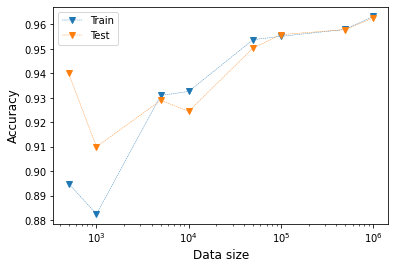

In [ ]:
# improve and save the previous plot
plt.subplots(figsize = (6, 4))
plt.plot(data_size, train_accuracy, 'v--', linewidth=0.4,  label= 'Train')
plt.plot(data_size, test_accuracy, 'v--', linewidth=0.4,  label= 'Test')
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Data size", fontsize =12)
plt.legend()
plt.xscale('log')
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_data_size.eps', format='eps', bbox_inches='tight')
plt.show()

## DNN : variables analysis

In [ ]:
%tensorflow_version 2.x
import shutil
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import tensorflow
device_name = tensorflow.test.gpu_device_name()
tensorflow.device('/device:GPU:0')
from tensorflow.keras.layers import Input
from keras.models import load_model
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# read the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")

data_size = 10000  # data size
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)

In [ ]:
#define some variables
eta_vals = np.logspace(-5, 1, 7)        # learning rate array
lmbd_vals = np.logspace(-5, 1, 7)       # lambda
n_neuron=np.logspace(0,3,4,dtype=int)   # neurons per hidden layer
n_layer = 4                             # hidden layers
epochs = 100
batch_size = 100
n_categories = 4                        # outputs
inputsize = X_train.shape[1]            # shape of train data

In [ ]:
# CREATE A LOOP FOR ALL THE VARIABLES ABOVE 
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), n_layer), dtype=object) #to store all the info
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        for k, n_neur in enumerate(n_neuron):
            for l in range(n_layer):
                DNN = NN_model(inputsize,l, n_neur, n_categories, eta=eta, lamda=lmbd)
                # Fit the model
                DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                
                filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{l}-size-{data_size}.h5"
                DNN.save(filepath)

                # copy the model to google drive
                shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")
                scores = DNN.evaluate(X_test, Y_test)
                DNN_keras[i][j][k][l] = DNN

                print("Learning rate = ", eta)
                print("Lambda = ", lmbd)
                print("neuron_layer = ", n_neur) 
                print("layers = ", l) 

                print("Test accuracy: %.3f" % scores[1])
                print()

63/63 [==============================] - 0s 3ms/step - loss: 0.6473 - acc: 0.7735
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  1
layers =  0
Test accuracy: 0.774

63/63 [==============================] - 0s 3ms/step - loss: 0.4964 - acc: 0.8650
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  1
layers =  1
Test accuracy: 0.865

63/63 [==============================] - 0s 4ms/step - loss: 0.8528 - acc: 0.5595
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  1
layers =  2
Test accuracy: 0.559

63/63 [==============================] - 0s 4ms/step - loss: 0.8528 - acc: 0.5595
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  1
layers =  3
Test accuracy: 0.559

63/63 [==============================] - 1s 4ms/step - loss: 0.6335 - acc: 0.8030
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  10
layers =  0
Test accuracy: 0.803

63/63 [==============================] - 0s 3ms/step - loss: 0.4074 - acc: 0.8785
Learning rate =  0.01
Lambda =  1e-05
neuron_layer =  10


In [ ]:
#Now create a loop to calculate the training and test accuray (loading the saved data)
DNN_keras_acc_train = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), n_layer), dtype=object)
DNN_keras_acc_test = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), n_layer), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        for k, n_neur in enumerate(n_neuron):
            for l in range(n_layer):
                
                drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
                filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{l}-size-{data_size}.h5"
                DNN = load_model(filepath)

                DNN_keras_acc_test[i][j][k][l]  = DNN.evaluate(X_test, Y_test)[1]
                DNN_keras_acc_train[i][j][k][l]  = DNN.evaluate(X_train, Y_train)[1]


250/250 [==============================] - 4s 15ms/step - loss: nan - acc: 0.0033


In [ ]:
def get_indices_of_k_smallest(arr, k):
    '''function to get the k smallest indices of the values in a matrix/arr'''
    idx = np.argpartition(arr.ravel(), k)
    return np.array(np.unravel_index(idx, arr.shape))[:, range(k)].transpose().tolist()

In [ ]:
# calculate all the total number of k elements of the matrix
values_test =  np.prod(DNN_keras_acc_test.shape)
values_train =  np.prod(DNN_keras_acc_train.shape)

In [ ]:
# calculate the all the indices from the smallest to the largest accuracy
indices_test = get_indices_of_k_smallest(DNN_keras_acc_test, values_test-1)
indices_train = get_indices_of_k_smallest(DNN_keras_acc_train, values_test-1)

In [ ]:
# print the best 10 parameter combinations to get the largest test accuracies 
best = 10
print(f"Best {best} combinations:")
for i in range(best):
  v_eta = indices_test[-best:][i][0]
  v_lmbd = indices_test[-best:][i][1]
  v_neuron = indices_test[-best:][i][2]
  v_layer = indices_test[-best:][i][3]
  acc = DNN_keras_acc_test[indices_test[-best:][i][0]][indices_test[-best:][i][1]][indices_test[-best:][i][2]][indices_test[-best:][i][3]]
  print(f"Learning rate = {eta_vals[v_eta]}, Lambda = {lmbd_vals[v_lmbd]}, h_layer = {v_layer}, neuron/layer = {n_neuron[v_neuron]}, Test accuracy = {acc}" )


Best 10 combinations:
Learning rate = 0.1, Lambda = 1e-05, h_layer = 1, neuron/layer = 1000, Test accuracy = 0.9399999976158142
Learning rate = 0.1, Lambda = 0.0001, h_layer = 2, neuron/layer = 10, Test accuracy = 0.9415000081062317
Learning rate = 0.1, Lambda = 0.0001, h_layer = 3, neuron/layer = 1000, Test accuracy = 0.9424999952316284
Learning rate = 0.1, Lambda = 0.0001, h_layer = 2, neuron/layer = 100, Test accuracy = 0.9459999799728394
Learning rate = 0.1, Lambda = 1e-05, h_layer = 2, neuron/layer = 10, Test accuracy = 0.9465000033378601
Learning rate = 0.1, Lambda = 1e-05, h_layer = 2, neuron/layer = 1000, Test accuracy = 0.9495000243186951
Learning rate = 0.1, Lambda = 0.0001, h_layer = 2, neuron/layer = 1000, Test accuracy = 0.9505000114440918
Learning rate = 0.1, Lambda = 1e-05, h_layer = 3, neuron/layer = 10, Test accuracy = 0.9520000219345093
Learning rate = 0.1, Lambda = 1e-05, h_layer = 2, neuron/layer = 100, Test accuracy = 0.9520000219345093
Learning rate = 0.1, Lambda 

In [ ]:
print("Coincidentally, the best 10 accuracies are obtained with learnig rate= 0.1 but seems posssible to increase the accuracy reducing the lambda value, increasing the h_layer and the neurons per layer")

Coincidentally, the best 10 accuracies are obtained with learnig rate= 0.1 but seems posssible to increase the accuracy reducing the lambda value, increasing the h_layer and the neurons per layer


### Redo the previous calculation but with new parameters

In [ ]:
eta_vals = [0.1]                        # fix because gives the best accuracies
lmbd_vals = np.logspace(-10, -6, 5)     # smaller lambda values
n_neuron=np.logspace(1,3,3,dtype=int)   # more hidden layers
n_layer = [2,3,4,5]
epochs = 100
batch_size = 100
n_categories = 4                        # outputs (4 particles)
inputsize = X_train.shape[1]

In [ ]:
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), len(n_layer)), dtype=object)
        
for i, eta in tqdm(enumerate(eta_vals)):
    for j, lmbd in enumerate(lmbd_vals):
        for k, n_neur in enumerate(n_neuron):
            for l, layer in enumerate(n_layer):
                DNN = NN_model(inputsize,layer, n_neur, n_categories, eta=eta, lamda=lmbd)
                # Fit the model
                DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                
                filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
                DNN.save(filepath)

                # copy it there
                shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")
                scores = DNN.evaluate(X_test, Y_test)
                DNN_keras[i][j][k][l] = DNN

                print("Learning rate = ", eta)
                print("Lambda = ", lmbd)
                print("neuron_layer = ", n_neur) 
                print("layers = ", layer) 

                print("Test accuracy: %.3f" % scores[1])
                print()

0it [00:00, ?it/s]

63/63 [==============================] - 0s 3ms/step - loss: 0.1785 - acc: 0.9355
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  10
layers =  2
Test accuracy: 0.936

63/63 [==============================] - 0s 3ms/step - loss: 0.1646 - acc: 0.9410
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  10
layers =  3
Test accuracy: 0.941

63/63 [==============================] - 0s 3ms/step - loss: 0.2771 - acc: 0.9100
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  10
layers =  4
Test accuracy: 0.910

63/63 [==============================] - 0s 4ms/step - loss: 0.4983 - acc: 0.8400
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  10
layers =  5
Test accuracy: 0.840

63/63 [==============================] - 0s 3ms/step - loss: 0.1606 - acc: 0.9410
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  100
layers =  2
Test accuracy: 0.941

63/63 [==============================] - 0s 3ms/step - loss: 0.1451 - acc: 0.9460
Learning rate =  0.1
Lambda =  1e-10
neuron_layer =  100


1it [36:06, 2166.04s/it]

Learning rate =  0.1
Lambda =  1e-06
neuron_layer =  1000
layers =  5
Test accuracy: 0.899



In [ ]:
DNN_keras_acc_train = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), len(n_layer)), dtype=object)
DNN_keras_acc_test = np.zeros((len(eta_vals), len(lmbd_vals), len(n_neuron), len(n_layer)), dtype=object)


for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        for k, n_neur in enumerate(n_neuron):
            for l, layer in enumerate(n_layer):
                
                drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
                filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
                DNN = load_model(filepath)

                DNN_keras_acc_test[i][j][k][l]  = DNN.evaluate(X_test, Y_test)[1]
                DNN_keras_acc_train[i][j][k][l]  = DNN.evaluate(X_train, Y_train)[1]

250/250 [==============================] - 2s 5ms/step - loss: 0.2565 - acc: 0.8996


In [ ]:
# calculate all the total number of k elements of the matrix
values_test =  np.prod(DNN_keras_acc_test.shape)
values_train =  np.prod(DNN_keras_acc_train.shape)

In [ ]:
# get the indices from the smallest to the largest accuracies
indices_test = get_indices_of_k_smallest(DNN_keras_acc_test, values_test-1)
indices_train = get_indices_of_k_smallest(DNN_keras_acc_train, values_test-1)

In [ ]:
# coincidentally, either training and test accuracies have the same indices for the best 7 values
print(indices_test[-7:])
print(indices_train[-7:])

[[0, 4, 2, 2], [0, 1, 1, 3], [0, 2, 1, 2], [0, 2, 2, 1], [0, 2, 1, 3], [0, 0, 1, 2], [0, 1, 1, 2]]
[[0, 4, 2, 2], [0, 1, 1, 3], [0, 2, 1, 2], [0, 2, 2, 1], [0, 1, 1, 2], [0, 2, 1, 3], [0, 0, 1, 2]]


In [ ]:
best = 10
print(f"Best {best} combinations:")
for i in range(best):
  v_eta = indices_test[-best:][i][0]
  v_lmbd = indices_test[-best:][i][1]
  v_neuron = indices_test[-best:][i][2]
  v_layer = indices_test[-best:][i][3]
  acc = DNN_keras_acc_test[indices_test[-best:][i][0]][indices_test[-best:][i][1]][indices_test[-best:][i][2]][indices_test[-best:][i][3]]
  print(f"Learning rate = {eta_vals[v_eta]}, Lambda = {lmbd_vals[v_lmbd]}, h_layer = {n_layer[v_layer]}, neuron/layer = {n_neuron[v_neuron]}, Test accuracy = {acc}" )

Best 10 combinations:
Learning rate = 0.1, Lambda = 1e-06, h_layer = 3, neuron/layer = 100, Test accuracy = 0.949999988079071
Learning rate = 0.1, Lambda = 1e-10, h_layer = 5, neuron/layer = 1000, Test accuracy = 0.949999988079071
Learning rate = 0.1, Lambda = 1e-09, h_layer = 4, neuron/layer = 1000, Test accuracy = 0.9509999752044678
Learning rate = 0.1, Lambda = 1e-06, h_layer = 4, neuron/layer = 1000, Test accuracy = 0.9509999752044678
Learning rate = 0.1, Lambda = 1e-09, h_layer = 5, neuron/layer = 100, Test accuracy = 0.9520000219345093
Learning rate = 0.1, Lambda = 1e-08, h_layer = 4, neuron/layer = 100, Test accuracy = 0.9524999856948853
Learning rate = 0.1, Lambda = 1e-08, h_layer = 3, neuron/layer = 1000, Test accuracy = 0.953499972820282
Learning rate = 0.1, Lambda = 1e-08, h_layer = 5, neuron/layer = 100, Test accuracy = 0.9539999961853027
Learning rate = 0.1, Lambda = 1e-10, h_layer = 4, neuron/layer = 100, Test accuracy = 0.9545000195503235
Learning rate = 0.1, Lambda = 1e

In [ ]:
print('From the results we can estimate that the best accuracy are given by: Learning rate = 0.1, Lambda = 1e-09, h_layer = 4, neuron/layer = 100')

From the results we can estimate that the best accuracy are given by: Learning rate = 0.1, Lambda = 1e-09, h_layer = 4, neuron/layer = 100


**Let's see the evolution of the variables with plots:**

In [ ]:
# First check how the accuracy depends of the lambda a number of layers
eta = 0.1
lmbds = np.logspace(-10, 1, 12)
n_neur = 100
layers = [1,2,3, 4, 5]
data_size = 10000
n_categories = 4
epochs = 100
batch_size = 100
inputsize = X_train.shape[1]
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
plt.subplots(figsize = (6, 5))

for layer in layers: 
  DNN_keras_acc_test, DNN_keras_acc_train  = [], []
  for i, lmbd in enumerate(lmbds):
    filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
    try: 
      DNN = load_model(filepath) # load the model if it is save in drive
    except:
      # If the model is not saved in drive, create it
      DNN = NN_model(inputsize,layer, n_neur, n_categories, eta=eta, lamda=lmbd)
      DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                  
      filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
      DNN.save(filepath)

      # copy to drive
      shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")

    DNN_keras_acc_test.append(DNN.evaluate(X_test, Y_test)[1])
    #DNN_keras_acc_train.append(DNN.evaluate(X_train, Y_train)[1])
  plt.plot(lmbds, DNN_keras_acc_test,'v--', linewidth=0.4, label= f'h_layers = {layer}')
  #plt.plot(lmbds, DNN_keras_acc_train, label= f'train, h_layer = {layer}')
plt.xscale('log')
plt.ylabel("Accuracy", fontsize = 12)
plt.xlabel("$\lambda$",  fontsize = 12)
plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_hlayer.eps', format='eps', bbox_inches='tight')
plt.show()

63/63 [==============================] - 0s 1ms/step - loss: nan - acc: 0.0045


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
# Now calculate how the accuracy depends of the number of neurons and lambda
eta = 0.1
lmbds = np.logspace(-10, 1, 12)
n_neurs = [10, 100, 1000]
layer = 4
data_size = 10000
n_categories = 4
epochs = 100
batch_size = 100
inputsize = X_train.shape[1]
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
plt.subplots(figsize = (6, 5))
for n_neur in n_neurs: 
  DNN_keras_acc_test, DNN_keras_acc_train  = [], []
  for i, lmbd in enumerate(lmbds):
    filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
    try: 
      DNN = load_model(filepath)
    except:
      DNN = NN_model(inputsize,layer, n_neur, n_categories, eta=eta, lamda=lmbd)
      # Fit the model
      DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                  
      filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}.h5"
      DNN.save(filepath)

      # copy it there
      shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")

    DNN_keras_acc_test.append(DNN.evaluate(X_test, Y_test)[1])
    #DNN_keras_acc_train.append(DNN.evaluate(X_train, Y_train)[1])
  plt.plot(lmbds, DNN_keras_acc_test, 'v--', linewidth=0.4,  label= f'neurons/layer = {n_neur}')
  #plt.plot(lmbds, DNN_keras_acc_train, label= f'train, neurons = {n_neur}')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("$\lambda$", fontsize =12)
plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_layer.eps', format='eps', bbox_inches='tight')
plt.show()

63/63 [==============================] - 1s 9ms/step - loss: nan - acc: 0.0045


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


**Study of eta and lambda**

In [ ]:
data_size = 10000 
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])
# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)

In [ ]:
# define variables
inputsize = X_train.shape[1]
epochs = 100
batch_size = 100
n_neuron = 100
n_categories = 4
n_layers = 2     # the best if 4, but is time consuming for that reason 2 which gives similar results
eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-6, -1, 6)

63/63 [==============================] - 0s 4ms/step - loss: 0.8543 - acc: 0.5585


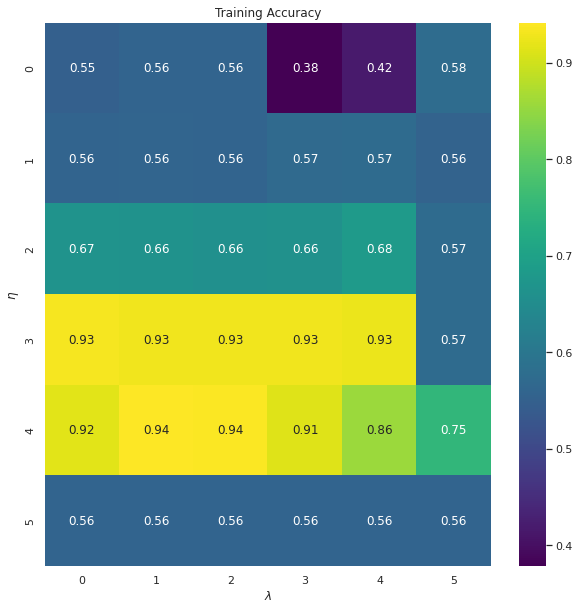

In [ ]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"

for i,eta  in enumerate(eta_vals):
    for j,lamda  in enumerate(lmbd_vals):
        file_name = f"model-lr-{eta}-lb-{lamda}-neur-{n_neuron}-lay-{n_layers}-size-{data_size}.h5"
        
        try:
          DNN = load_model(drive_path+file_name)
        except:
          #print('not loaded: '+drive_path+file_name)
          DNN = NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lamda)
          DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
          DNN.save(local_path+ file_name)
          # copy it there
          shutil.copy2( local_path+file_name, drive_path)

        train_accuracy[i][j] = DNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test, Y_test)[1]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

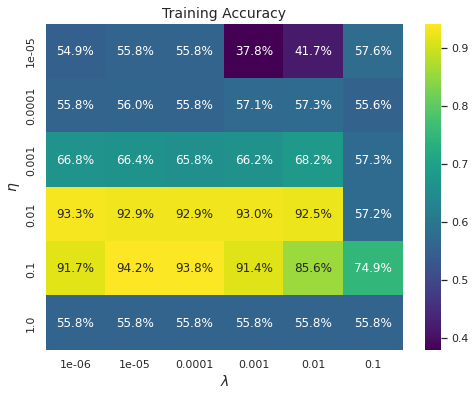

In [ ]:
# plot the training results using a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(train_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Training Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/dnn_acc_train_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

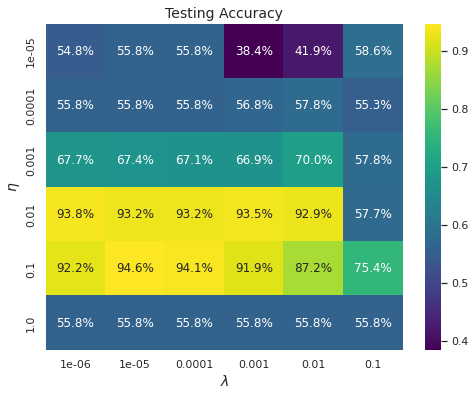

In [ ]:
# plot the test results using a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(test_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Testing Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/dnn_acc_test_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

## Now scaling the data

In [ ]:
# read the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")

data_size = 10000  # data size
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# define variables
inputsize = X_train.shape[1]
epochs = 100
batch_size = 100
n_neuron = 100
n_categories = 4
n_layers = 2     # the best if 4, but is time consuming for that reason 2 which gives similar results
eta_vals = np.logspace(-4, 1, 6)
lmbd_vals = np.logspace(-9, -4, 6)

63/63 [==============================] - 0s 4ms/step - loss: nan - acc: 0.0010


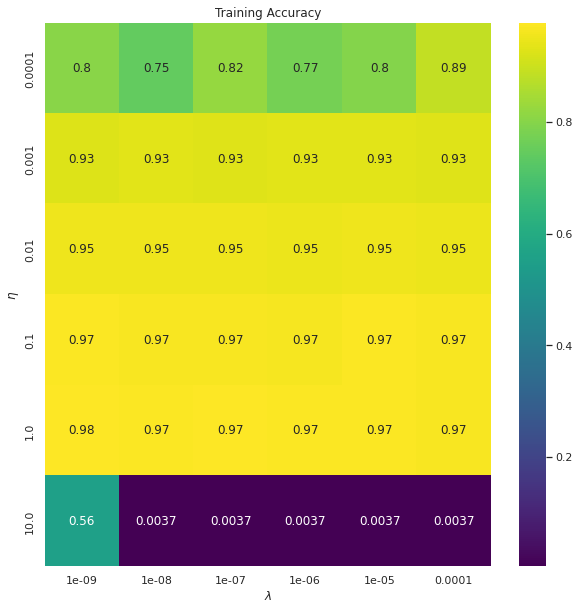

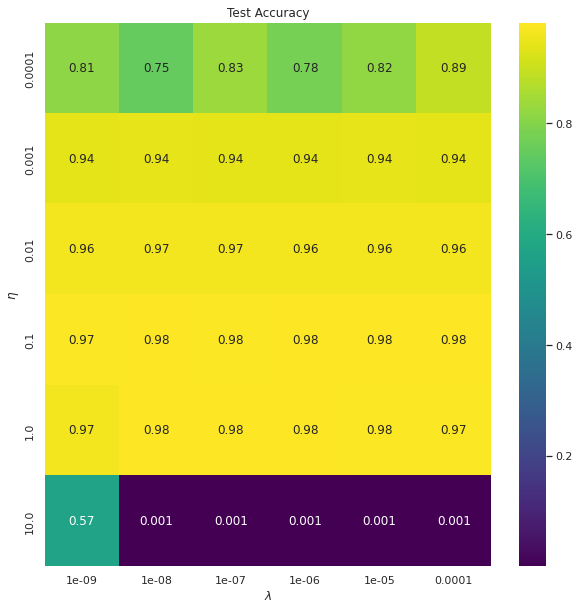

In [ ]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"

for i,eta  in enumerate(eta_vals):
    for j,lamda  in enumerate(lmbd_vals):
        file_name = f"model-lr-{eta}-lb-{lamda}-neur-{n_neuron}-lay-{n_layers}-size-{data_size}-scaled.h5"
        
        try:
          DNN = load_model(drive_path+file_name)
        except:
          #print('not loaded: '+drive_path+file_name)
          DNN = NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lamda)
          DNN.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
          DNN.save(local_path+ file_name)
          # copy it there
          shutil.copy2( local_path+file_name, drive_path)

        train_accuracy[i][j] = DNN.evaluate(X_train_scaled, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test_scaled, Y_test)[1]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")

x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels

plt.show()

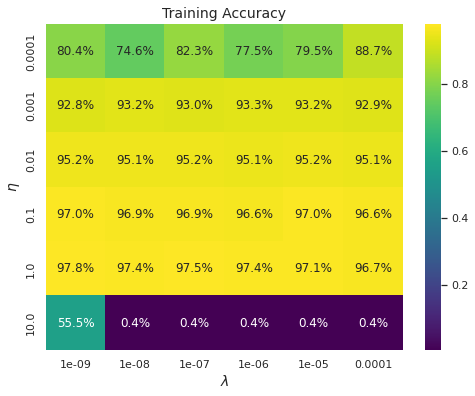

In [ ]:
# plot the training results using a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(train_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Training Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/dnn_acc_scal_train_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

63/63 [==============================] - 0s 4ms/step - loss: nan - acc: 0.0035


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


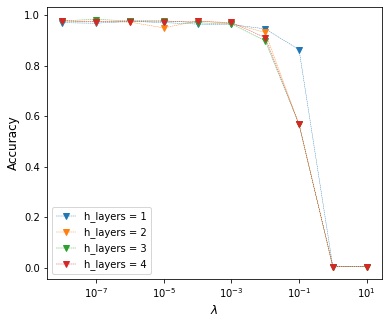

In [ ]:
# First check how the accuracy depends of the lambda a number of layers
eta = 1
lmbds = np.logspace(-8, 1, 10)
n_neur = 100
layers = [1,2,3, 4]
data_size = 10000
n_categories = 4
epochs = 100
batch_size = 100
inputsize = X_train.shape[1]
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
plt.subplots(figsize = (6, 5))

for layer in layers: 
  DNN_keras_acc_test, DNN_keras_acc_train  = [], []
  for i, lmbd in enumerate(lmbds):
    filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}-scaled.h5"
    try: 
      DNN = load_model(filepath) # load the model if it is save in drive
    except:
      # If the model is not saved in drive, create it
      DNN = NN_model(inputsize,layer, n_neur, n_categories, eta=eta, lamda=lmbd)
      DNN.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                  
      filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}-scaled.h5"
      DNN.save(filepath)

      # copy to drive
      shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")

    DNN_keras_acc_test.append(DNN.evaluate(X_test_scaled, Y_test)[1])
    #DNN_keras_acc_train.append(DNN.evaluate(X_train, Y_train)[1])
  plt.plot(lmbds, DNN_keras_acc_test,'v--', linewidth=0.4, label= f'h_layers = {layer}')
  #plt.plot(lmbds, DNN_keras_acc_train, label= f'train, h_layer = {layer}')
plt.xscale('log')

plt.ylabel("Accuracy", fontsize = 12)
plt.xlabel("$\lambda$",  fontsize = 12)
plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_scaled_hlayer.eps', format='eps', bbox_inches='tight')
plt.show()

In [ ]:
# Now calculate how the accuracy depends of the number of neurons and lambda
eta = 0.1
lmbds = np.logspace(-8, 1, 10)
n_neurs = [10, 100, 1000]
layer = 2
data_size = 10000
n_categories = 4
epochs = 100
batch_size = 100
inputsize = X_train.shape[1]
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
plt.subplots(figsize = (6, 5))
for n_neur in n_neurs: 
  DNN_keras_acc_test, DNN_keras_acc_train  = [], []
  for i, lmbd in enumerate(lmbds):
    filepath = drive_path+f"model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}-scaled.h5"
    try: 
      DNN = load_model(filepath)
    except:
      DNN = NN_model(inputsize,layer, n_neur, n_categories, eta=eta, lamda=lmbd)
      # Fit the model
      DNN.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                  
      filepath=f"/content/sample_data/model-lr-{eta}-lb-{lmbd}-neur-{n_neur}-lay-{layer}-size-{data_size}-scaled.h5"
      DNN.save(filepath)

      # copy it there
      shutil.copy2( filepath, "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN")

    DNN_keras_acc_test.append(DNN.evaluate(X_test_scaled, Y_test)[1])
    #DNN_keras_acc_train.append(DNN.evaluate(X_train, Y_train)[1])
  plt.plot(lmbds, DNN_keras_acc_test, 'v--', linewidth=0.4,  label= f'neurons/layer = {n_neur}')
  #plt.plot(lmbds, DNN_keras_acc_train, label= f'train, neurons = {n_neur}')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("$\lambda$", fontsize =12)
plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/acc_scaled_layer.eps', format='eps', bbox_inches='tight')
plt.show()

63/63 [==============================] - 0s 4ms/step - loss: nan - acc: 0.0035


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# **2nd Model: Convolutional Neural Network**

---



In [1]:
# import packages
%tensorflow_version 2.x
import tensorflow 
import numpy as np
import pandas as pd
device_name = tensorflow.test.gpu_device_name()
tensorflow.device('/device:GPU:0')
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.layers import Input
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
#from tensorflow.keras import MaxPooling1D
#from tensorflow.keras import Flatten
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [2]:
# read and reshape the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")

data_size = 10000 
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])

# split into train and test data
# one-liner from scikit-learn library
x = X.values.reshape(X.shape[0], X.shape[1], 1) # this shape is for the 1D CNN
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=test_size)

Mounted at /content/drive


In [19]:
def create_convolutional_neural_network_keras(input_shape,receptive_field, n_filters, n_neurons_connected, n_categories, eta, lmbd):
    '''
        This function creates a CNN model using the following parameters:
        Input:
        - input_shape 
        - receptive_field
        - n_filters
        - n_neurons_connected: number of neurons in each hidden layer
        - n_categories: number of outputs (4 different particles)
        - eta: learning rate
        - lmdd: hyperparameter lambda
        Output
        - return all the model    
    '''
    
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=receptive_field, activation='relu', input_shape=(input_shape[1],input_shape[2]), kernel_regularizer=regularizers.l2(lmbd)))
    #model.add(Conv1D(filters=n_filters, kernel_size=receptive_field, activation='relu',  kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_neurons_connected, activation='relu',  kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(0.5))
    model.add(Dense(n_neurons_connected, activation='relu',  kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(n_categories, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))
    sgd = optimizers.SGD(learning_rate=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    # fit network
    return model

In [4]:
# Define the parameters for the CNN
epochs = 100
batch_size = 100
input_shape = X_train.shape
receptive_field = 2
n_filters = 64
n_neurons_connected = 100
n_categories = 4
n_layers = 2
eta_vals = np.logspace(-5, 0, 6)    # similar values than for DNN
lmbd_vals = np.logspace(-6, -1, 6)  # similar values than for DNN

63/63 [==============================] - 1s 6ms/step - loss: 0.8556 - accuracy: 0.5570


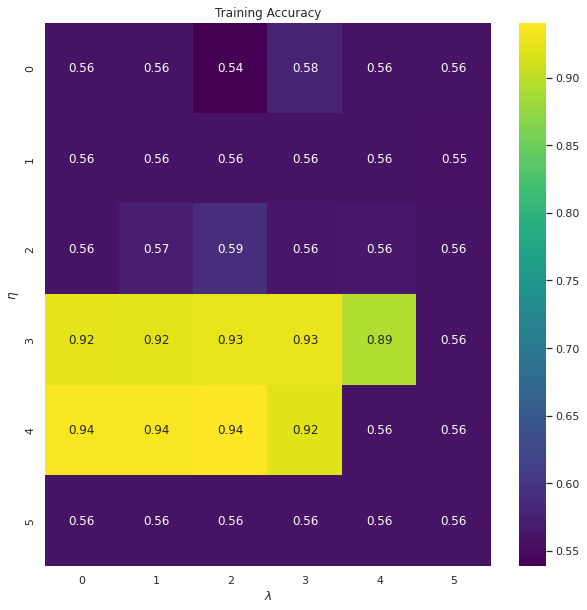

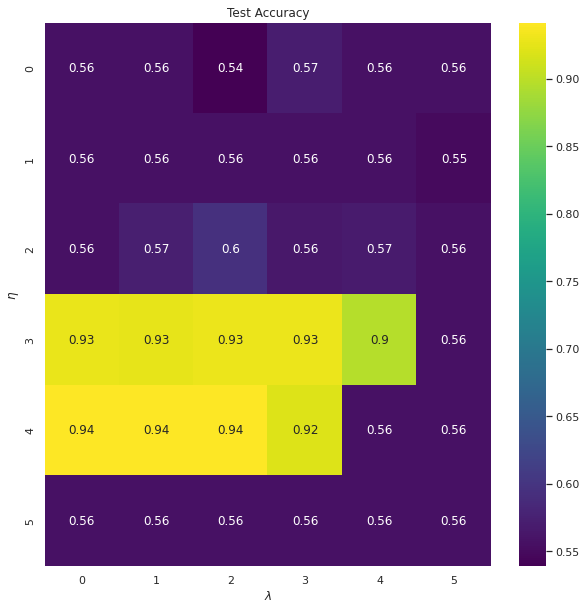

In [ ]:
# calculate the accuracies for all the learning rates and lambda combinations
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"

CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neurons_connected}-lay-{n_layers}-size-{data_size}.h5"
        try:
          CNN = load_model(drive_path+file_name)
        except:
          #print('not loaded: '+drive_path+file_name)
          CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
          CNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
          CNN.save(local_path+ file_name)
          # copy it there
          shutil.copy2( local_path+file_name, drive_path)
        train_accuracy[i][j] = CNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(X_test, Y_test)[1]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

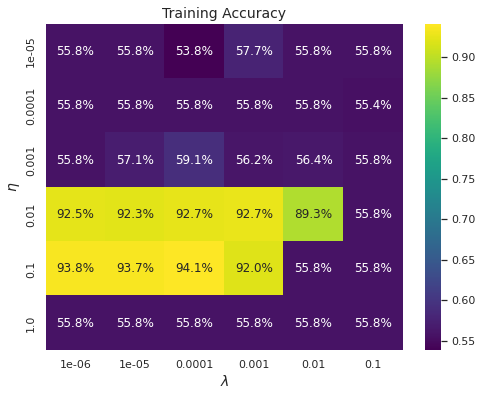

In [ ]:
# Plor the training accuracy in a heat map
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set()

fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(train_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Training Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/cnn_train_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

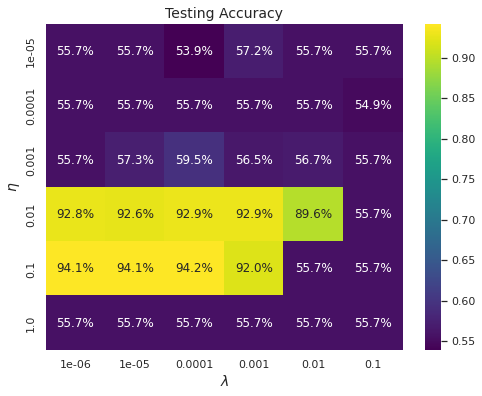

In [ ]:
# Plor the testing accuracy in a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(test_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Testing Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/cnn_test_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

### Scaling the data

In [34]:
# read and reshape the data
import shutil
from google.colab import drive
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")

data_size = 10000 
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])

# split into train and test data
# one-liner from scikit-learn library
#x = X.values.reshape(X.shape[0], X.shape[1], 1) # this shape is for the 1D CNN
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
X_train_scaled.shape
X_train.shape

(8000, 6)

In [21]:
# Define the parameters for the CNN
epochs = 100
batch_size = 100
input_shape = X_train_scaled.shape
receptive_field = 2
n_filters = 64
n_neurons_connected = 100
n_categories = 4
n_layers = 2
eta_vals = np.logspace(-4, 1, 6)
lmbd_vals = np.logspace(-9, -4, 6)

In [38]:
# calculate the accuracies for all the learning rates and lambda combinations
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"

CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neurons_connected}-lay-{n_layers}-size-{data_size}-scaled.h5"
        try:
          CNN = load_model(drive_path+file_name)
        except:
          #print('not loaded: '+drive_path+file_name)
          CNN = create_convolutional_neural_network_keras(input_shape, receptive_field, n_filters, n_neurons_connected, n_categories, eta, lmbd)
                #create_convolutional_neural_network_keras(input_shape,receptive_field, n_filters, n_neurons_connected, n_categories,  eta, lmbd)
          CNN.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
          CNN.save(local_path+ file_name)
          # copy it there
          shutil.copy2( local_path+file_name, drive_path)
        train_accuracy[i][j] = CNN.evaluate(X_train_scaled, Y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(X_test_scaled, Y_test)[1]


63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0040


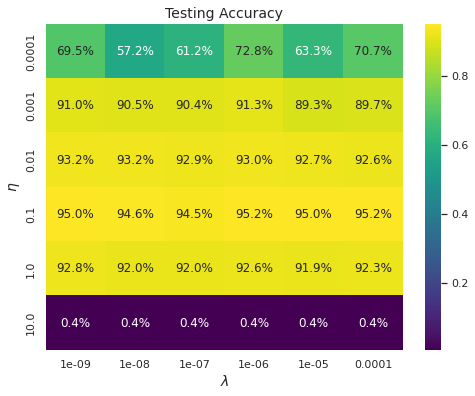

In [39]:
# Plor the testing accuracy in a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(test_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Testing Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/cnn_scaled_test_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()


# **3rd Model MLP Model**

In [41]:
# import the packages for the model
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score
import seaborn as sns
import shutil

In [5]:
# read the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/pid-5M.csv")

data_size = 10000 
X = data[0:data_size].drop('id',axis=1 ,inplace=False)
y = pd.get_dummies(data[0:data_size]['id'])
# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
def create_MLP(eta, lmbd, neurons, epochs=100):
    '''
    This function creates a simple MLP model taking as inputs:
    - eta  : learning rate
    - lmbd : lambda values
    - neurons
    '''

    #model = MLPClassifier(learning_rate='constant', learning_rate_init=eta, solver='sgd', alpha=lmbd)
    model = MLPClassifier(hidden_layer_sizes=(neurons), activation='relu', alpha=lmbd, solver='sgd', learning_rate_init=eta, max_iter=epochs)
    # fit network
    return model

In [ ]:
# Define the values for the variables (Similar values for CNN and DNN)
n_layers = 2
epochs = 100
n_neurons_connected = 100
eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-6, -1, 6)

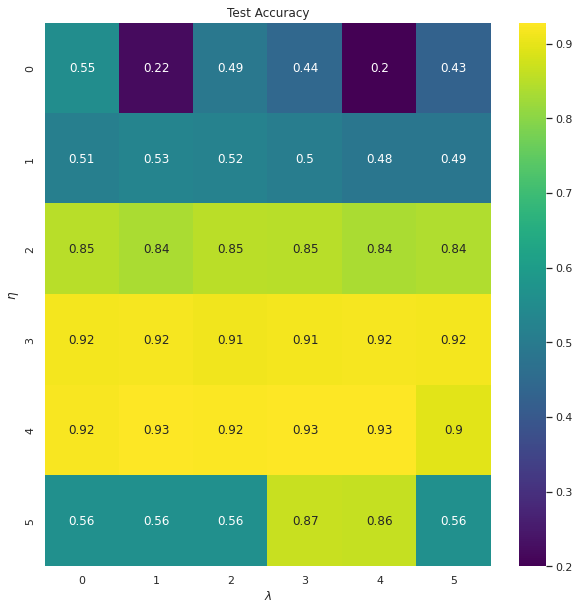

In [ ]:
# Train the model for the different eta and lmbd parameters and save the accuracies
MLP_train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
MLP_test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
MLP_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
      file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neurons_connected}-lay-{n_layers}-size-{data_size}.sav"
      try:
        MLP = pickle.load(open(drive_path+file_name, 'rb'))
      except:
        MLP = create_MLP(eta, lmbd,n_neurons_connected, epochs)
        MLP.fit(X_train, Y_train)
        pickle.dump(MLP, open(local_path+file_name, 'wb'))
        #MLP.save(local_path+ file_name)
        shutil.copy2( local_path+file_name, drive_path)
      
      pred_MLP = MLP.predict(X_train)
      MLP_train_accuracy[i][j]  = accuracy_score(Y_train, pred_MLP)
      pred_MLP = MLP.predict(X_test)
      MLP_test_accuracy[i][j]  = accuracy_score(Y_test, pred_MLP)


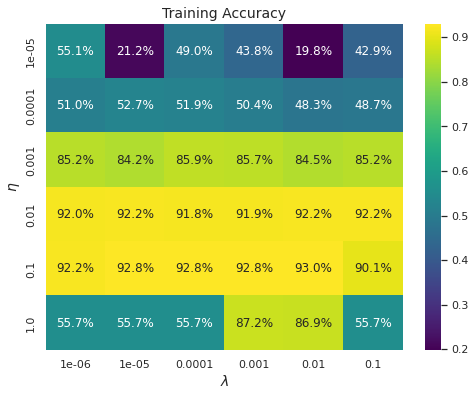

In [ ]:
# plot the training accuracy in a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(MLP_train_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Training Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/mlp_train_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

In [ ]:
# plot the test accuracy in a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(MLP_test_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Testing Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/mlp_test_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

## Scaling the data

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Define the values for the variables (Similar values for CNN and DNN)
n_layers = 2
epochs = 100
n_neurons_connected = 100
eta_vals = np.logspace(-4, 1, 6)
lmbd_vals = np.logspace(-9, -4, 6)

In [46]:
# Train the model for the different eta and lmbd parameters and save the accuracies
MLP_train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
MLP_test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
local_path = "/content/sample_data/"
drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
MLP_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
      file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neurons_connected}-lay-{n_layers}-size-{data_size}-scaled.sav"
      try:
        MLP = pickle.load(open(drive_path+file_name, 'rb'))
      except:
        MLP = create_MLP(eta, lmbd,n_neurons_connected, epochs)
        MLP.fit(X_train_scaled, Y_train)
        pickle.dump(MLP, open(local_path+file_name, 'wb'))
        #MLP.save(local_path+ file_name)
        shutil.copy2( local_path+file_name, drive_path)
      
      pred_MLP = MLP.predict(X_train_scaled)
      MLP_train_accuracy[i][j]  = accuracy_score(Y_train, pred_MLP)
      pred_MLP = MLP.predict(X_test_scaled)
      MLP_test_accuracy[i][j]  = accuracy_score(Y_test, pred_MLP)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

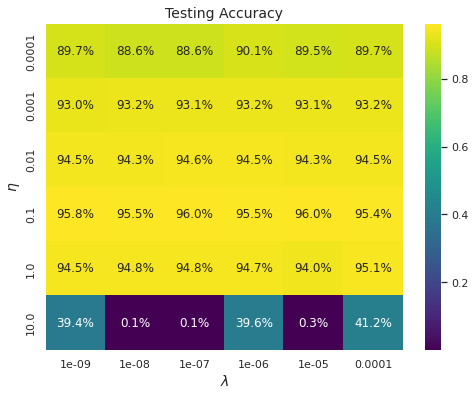

In [47]:
# plot the test accuracy in a heat map
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(MLP_test_accuracy, annot=True, fmt=".1%", ax=ax, cmap="viridis")
ax.set_title("Testing Accuracy", fontsize= 14)
ax.set_ylabel("$\eta$", fontsize= 14 )
ax.set_xlabel("$\lambda$", fontsize= 14)
x_values = np.array([i+0.5 for i in range(len(lmbd_vals))])
y_values = np.array([i+0.5 for i in range(len(eta_vals))])
ax.set_xticks(x_values) # values
ax.set_xticklabels(lmbd_vals) # labels
ax.set_yticks(y_values) # values
ax.set_yticklabels(eta_vals) # labels
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/mlp__scaled_test_acc_n_l.eps', format='eps', bbox_inches='tight')
plt.show()

# **STUDY OF THE DATA SIZE FOR ALL THE MODELS**

In [1]:
# import all the required packages
%tensorflow_version 2.x
import tensorflow 
import pickle
import numpy as np
import pandas as pd
import shutil
from time import time
import matplotlib.pyplot as plt 
from keras.models import load_model
device_name = tensorflow.test.gpu_device_name()
tensorflow.device('/device:GPU:0')
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.layers import Input
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
#from tensorflow.keras import MaxPooling1D
#from tensorflow.keras import Flatten
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
# define all the variables
data_size = [500, 1000, 5000, 10000, 50000, 100000]
eta = 0.1
lmbd = 0.0001
n_neuron=100
n_layers = 2
epochs = 100
batch_size = 100
n_categories = 4
receptive_field = 2
n_filters = 64

In [ ]:
# calculate the required time for the 3 models and save the models.
dnn_train_accuracy, dnn_test_accuracy = [], []
cnn_train_accuracy, cnn_test_accuracy = [], []
mlp_train_accuracy, mlp_test_accuracy = [], []

for size in data_size:
    local_path = "/content/sample_data/"
    dnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
    cnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"
    mlp_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
    file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neuron}-lay-{n_layers}-size-{size}.h5"
    
    X = data[0:size].drop('id',axis=1 ,inplace=False)
    y = pd.get_dummies(data[0:size]['id'])
      
    # split into train and test data
    train_size = 0.8
    test_size = 1 - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)
    inputsize = X_train.shape[1]
    x = X.values.reshape(X.shape[0], X.shape[1], 1)
    Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(x, y, test_size=test_size)
    input_shape = Xc_train.shape
    #Creating the models
    DNN = NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lmbd)
    CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                  n_filters, n_neuron, n_categories,
                                  eta, lmbd)
    MLP = create_MLP(eta, lmbd, n_neuron , epochs)

    #Fitting the models
    t1 = time()
    DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    t2 = time()
    CNN.fit(Xc_train, Yc_train, epochs=epochs, batch_size=batch_size, verbose=0)
    t3 = time()
    MLP.fit(X_train, Y_train)
    t4 = time()
    print(f'DNN model, data size = {size}, time = {t2-t1}')
    print(f'CNN model, data size = {size}, time = {t3-t2}')
    print(f'MLP model, data size = {size}, time = {t4-t3}')

    #Saving the models in drive
    DNN.save(dnn_drive_path+ file_name)
    CNN.save(cnn_drive_path+ file_name)
    pickle.dump(MLP, open(mlp_drive_path+file_name, 'wb'))

DNN model, data size = 500, time = 1.7879095077514648
CNN model, data size = 500, time = 2.3401520252227783
MLP model, data size = 500, time = 0.13888907432556152


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 1000, time = 3.3869268894195557
CNN model, data size = 1000, time = 3.7169744968414307
MLP model, data size = 1000, time = 0.3328990936279297


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 5000, time = 10.206367015838623
CNN model, data size = 5000, time = 21.15179681777954
MLP model, data size = 5000, time = 1.6554417610168457
DNN model, data size = 10000, time = 20.974148988723755
CNN model, data size = 10000, time = 27.87860131263733
MLP model, data size = 10000, time = 2.720383644104004


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 50000, time = 95.57651352882385
CNN model, data size = 50000, time = 135.6154534816742
MLP model, data size = 50000, time = 19.613286018371582


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 100000, time = 192.61314272880554
CNN model, data size = 100000, time = 322.6228914260864
MLP model, data size = 100000, time = 42.05827760696411


KeyboardInterrupt: ignored

In [ ]:
# Plot the results
DNN = [1.0705795288085938,  1.5822844505310059, 10.669353008270264,  10.654999256134033,  50.53340291976929,  100.42327976226807]
CNN = [3.418046712875366, 5.782433032989502, 20.85921835899353, 82.75763201713562, 158.32402324676514, 356.20503973960876]
MLP = [ 0.15140271186828613, 0.2824864387512207, 1.319472074508667,  2.269707679748535, 16.167301893234253, 37.32500076293945 ]
data_size = [500, 1000, 5000, 10000, 50000, 100000]

m, b = np.polyfit(np.log(data_size),np.log(DNN),1)
m1, b1 = np.polyfit(np.log(data_size),np.log(CNN),1)
m2, b2 = np.polyfit(np.log(data_size),np.log(MLP),1)

fig, ax = plt.subplots(figsize = (6, 5))
plt.plot(data_size , DNN,"v--", linewidth= 0.8, label= 'DNN')
plt.plot(data_size , CNN,"v--",  linewidth= 0.8, label= 'CNN')
plt.plot(data_size , MLP,"v--",  linewidth= 0.8, label= 'MLP')
plt.xscale('log')
plt.yscale('log')

plt.ylabel("time [s]", fontsize = 12)
plt.xlabel("Data size", fontsize = 12)

plt.legend()
#plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/time_models.eps', format='eps', bbox_inches='tight')


In [9]:
# Now load the models saved in Drive and calculate the accuracies
import shutil
import matplotlib.pyplot as plt 
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
dnn_train_accuracy, dnn_test_accuracy = [], []
cnn_train_accuracy, cnn_test_accuracy = [], []
mlp_train_accuracy, mlp_test_accuracy = [], []

for size in data_size:
    local_path = "/content/sample_data/"
    dnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
    cnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"
    mlp_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
    file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neuron}-lay-{n_layers}-size-{size}.h5"
    
    X = data[0:size].drop('id',axis=1 ,inplace=False)
    y = pd.get_dummies(data[0:size]['id'])
      
    # split into train and test data
    train_size = 0.8
    test_size = 1 - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)
    inputsize = X_train.shape[1]
    x = X.values.reshape(X.shape[0], X.shape[1], 1)
    Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(x, y, test_size=test_size)
    input_shape = Xc_train.shape
    #Loading the models

    DNN = load_model(dnn_drive_path+ file_name)
    CNN = load_model(cnn_drive_path+ file_name)
    MLP = pickle.load(open(mlp_drive_path+file_name, 'rb'))

    dnn_train_accuracy.append( DNN.evaluate(X_train, Y_train)[1])
    dnn_test_accuracy.append(CNN.evaluate(X_test, Y_test)[1])

    cnn_train_accuracy.append( CNN.evaluate(Xc_train, Yc_train)[1])
    cnn_test_accuracy.append( CNN.evaluate(Xc_test, Yc_test)[1])
    

    pred_MLP = MLP.predict(X_train)
    mlp_train_accuracy.append(accuracy_score(Y_train, pred_MLP))
    pred_MLP = MLP.predict(X_test)
    mlp_test_accuracy.append(accuracy_score(Y_test, pred_MLP))

625/625 [==============================] - 2s 3ms/step - loss: 0.1577 - accuracy: 0.9578


In [ ]:
#Plot the test accuracy as function of the data size
fig, ax = plt.subplots(figsize = (6, 5))
plt.plot(data_size , dnn_test_accuracy,"v--", linewidth= 0.8, label= 'DNN')
plt.plot(data_size , cnn_test_accuracy,"v--",  linewidth= 0.8, label= 'CNN')
plt.plot(data_size , mlp_test_accuracy,"v--",  linewidth= 0.8, label= 'MLP')
plt.xscale('log')
#plt.yscale('log')

plt.ylabel("accuracy", fontsize = 12)
plt.xlabel("Data size", fontsize = 12)

plt.legend()
#plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/test_acc_models.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


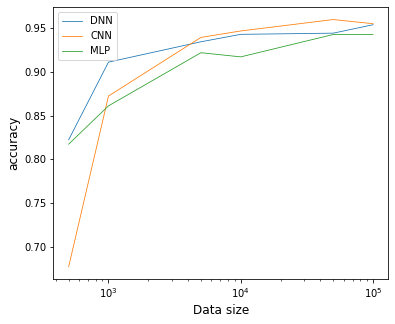

In [ ]:
#Plot the training accuracy as function of the data size
fig, ax = plt.subplots(figsize = (6, 5))
plt.plot(data_size , dnn_train_accuracy, linewidth= 0.8, label= 'DNN')
plt.plot(data_size , cnn_train_accuracy,  linewidth= 0.8, label= 'CNN')
plt.plot(data_size , mlp_train_accuracy,  linewidth= 0.8, label= 'MLP')
plt.xscale('log')
#plt.yscale('log')

plt.ylabel("accuracy", fontsize = 12)
plt.xlabel("Data size", fontsize = 12)

plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/train_acc_models.eps', format='eps', bbox_inches='tight')

In [54]:
# calculate the required time for the 3 models and save the models.
dnn_train_accuracy, dnn_test_accuracy = [], []
cnn_train_accuracy, cnn_test_accuracy = [], []
mlp_train_accuracy, mlp_test_accuracy = [], []

for size in data_size:
    local_path = "/content/sample_data/"
    dnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
    cnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"
    mlp_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
    file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neuron}-lay-{n_layers}-size-{size}-scaled.h5"
    
    X = data[0:size].drop('id',axis=1 ,inplace=False)
    y = pd.get_dummies(data[0:size]['id'])
      
    # split into train and test data
    train_size = 0.8
    test_size = 1 - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    inputsize = X_train_scaled.shape[1]

    #x = X.values.reshape(X.shape[0], X.shape[1], 1)
    Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(X, y, test_size=test_size)
    scaler = StandardScaler()
    scaler.fit(Xc_train)
    Xc_train_scaled = scaler.transform(Xc_train)
    Xc_train_scaled = Xc_train_scaled.reshape(Xc_train_scaled.shape[0], Xc_train_scaled.shape[1], 1)

    Xc_test_scaled = scaler.transform(Xc_test)
    Xc_test_scaled = Xc_test_scaled.reshape(Xc_test_scaled.shape[0], Xc_test_scaled.shape[1], 1)

    input_shape = Xc_train_scaled.shape
    #Creating the models
    DNN = NN_model(inputsize,n_layers,n_neuron,n_categories, eta,lmbd)
    CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                  n_filters, n_neuron, n_categories,
                                  eta, lmbd)
    MLP = create_MLP(eta, lmbd, n_neuron , epochs)

    #Fitting the models
    t1 = time()
    DNN.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    t2 = time()
    CNN.fit(Xc_train_scaled, Yc_train, epochs=epochs, batch_size=batch_size, verbose=0)
    t3 = time()
    MLP.fit(X_train_scaled, Y_train)
    t4 = time()
    print(f'DNN model, data size = {size}, time = {t2-t1}')
    print(f'CNN model, data size = {size}, time = {t3-t2}')
    print(f'MLP model, data size = {size}, time = {t4-t3}')

    #Saving the models in drive
    DNN.save(dnn_drive_path+ file_name)
    CNN.save(cnn_drive_path+ file_name)
    pickle.dump(MLP, open(mlp_drive_path+file_name, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 500, time = 1.7642841339111328
CNN model, data size = 500, time = 3.1474497318267822
MLP model, data size = 500, time = 0.21872949600219727


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 1000, time = 1.9627904891967773
CNN model, data size = 1000, time = 5.731066942214966
MLP model, data size = 1000, time = 0.3767085075378418


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 5000, time = 7.452595233917236
CNN model, data size = 5000, time = 24.661080837249756
MLP model, data size = 5000, time = 2.4384617805480957


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


DNN model, data size = 10000, time = 13.628543853759766
CNN model, data size = 10000, time = 46.56564736366272
MLP model, data size = 10000, time = 5.101634502410889
DNN model, data size = 50000, time = 82.40035510063171
CNN model, data size = 50000, time = 262.6498556137085
MLP model, data size = 50000, time = 28.276777505874634
DNN model, data size = 100000, time = 124.14634919166565
CNN model, data size = 100000, time = 562.6511771678925
MLP model, data size = 100000, time = 55.83740758895874


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


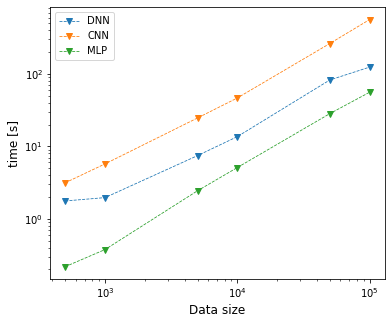

In [11]:
# Plot the results
DNN = [1.7642841339111328,  1.9627904891967773, 7.452595233917236,  13.628543853759766,  82.40035510063171,  124.14634919166565]
CNN = [3.1474497318267822, 5.731066942214966, 24.661080837249756, 46.56564736366272, 262.6498556137085, 562.6511771678925]
MLP = [0.21872949600219727, 0.3767085075378418, 2.4384617805480957,  5.101634502410889, 28.276777505874634, 55.83740758895874]
data_size = [500, 1000, 5000, 10000, 50000, 100000]

fig, ax = plt.subplots(figsize = (6, 5))
plt.plot(data_size , DNN,"v--", linewidth= 0.8, label= 'DNN')
plt.plot(data_size , CNN,"v--",  linewidth= 0.8, label= 'CNN')
plt.plot(data_size , MLP,"v--",  linewidth= 0.8, label= 'MLP')
plt.xscale('log')
plt.yscale('log')

plt.ylabel("time [s]", fontsize = 12)
plt.xlabel("Data size", fontsize = 12)

plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/time_models_scaled.eps', format='eps', bbox_inches='tight')

In [17]:
# Now load the models saved in Drive and calculate the accuracies
import shutil
import matplotlib.pyplot as plt 
from keras.models import load_model
dnn_train_accuracy, dnn_test_accuracy = [], []
cnn_train_accuracy, cnn_test_accuracy = [], []
mlp_train_accuracy, mlp_test_accuracy = [], []

for size in data_size:
    local_path = "/content/sample_data/"
    dnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/DNN/"
    cnn_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/CNN/"
    mlp_drive_path = "/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/MLP/"
    file_name = f"model-lr-{eta}-lb-{lmbd}-neur-{n_neuron}-lay-{n_layers}-size-{size}-scaled.h5"
    
    X = data[0:size].drop('id',axis=1 ,inplace=False)
    y = pd.get_dummies(data[0:size]['id'])
      
    train_size = 0.8
    test_size = 1 - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=train_size, test_size=test_size)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    inputsize = X_train_scaled.shape[1]

    #x = X.values.reshape(X.shape[0], X.shape[1], 1)
    Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(X, y, test_size=test_size)
    scaler = StandardScaler()
    scaler.fit(Xc_train)
    Xc_train_scaled = scaler.transform(Xc_train)
    Xc_train_scaled = Xc_train_scaled.reshape(Xc_train_scaled.shape[0], Xc_train_scaled.shape[1], 1)

    Xc_test_scaled = scaler.transform(Xc_test)
    Xc_test_scaled = Xc_test_scaled.reshape(Xc_test_scaled.shape[0], Xc_test_scaled.shape[1], 1)

    input_shape = Xc_train_scaled.shape
    #Loading the models

    DNN = load_model(dnn_drive_path+ file_name)
    CNN = load_model(cnn_drive_path+ file_name)
    MLP = pickle.load(open(mlp_drive_path+file_name, 'rb'))

    dnn_train_accuracy.append( DNN.evaluate(X_train_scaled, Y_train)[1])
    dnn_test_accuracy.append(CNN.evaluate(X_test_scaled, Y_test)[1])

    cnn_train_accuracy.append( CNN.evaluate(Xc_train_scaled, Yc_train)[1])
    cnn_test_accuracy.append( CNN.evaluate(Xc_test_scaled , Yc_test)[1])
    

    pred_MLP = MLP.predict(X_train_scaled)
    mlp_train_accuracy.append(accuracy_score(Y_train, pred_MLP))
    pred_MLP = MLP.predict(X_test_scaled)
    mlp_test_accuracy.append(accuracy_score(Y_test, pred_MLP))

625/625 [==============================] - 2s 3ms/step - loss: 0.1461 - accuracy: 0.9567


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


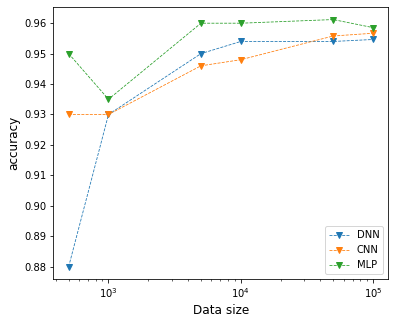

In [18]:
#Plot the test accuracy as function of the data size
fig, ax = plt.subplots(figsize = (6, 5))
plt.plot(data_size , dnn_test_accuracy,"v--", linewidth= 0.8, label= 'DNN')
plt.plot(data_size , cnn_test_accuracy,"v--",  linewidth= 0.8, label= 'CNN')
plt.plot(data_size , mlp_test_accuracy,"v--",  linewidth= 0.8, label= 'MLP')
plt.xscale('log')
#plt.yscale('log')

plt.ylabel("accuracy", fontsize = 12)
plt.xlabel("Data size", fontsize = 12)

plt.legend()
plt.savefig('/content/drive/MyDrive/MASTER_NUC_PHYSIC/THIRD_SEMESTER/MACHINE_LEARNING/test_acc_models_scaled.eps', format='eps', bbox_inches='tight')